Let's explore the last-layer embeddings in the QMIA model on C10 with Class 1 (automobile) held out.

In [2]:
import argparse
import os
import time

import torch
import numpy as np
import random

from lightning_utils import LightningQMIA
from data_utils import CustomDataModule
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import pytorch_lightning as pl

device = torch.device("cuda:2")
os.environ["CUDA_VISIBLE_DEVICES"]="2"

def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ("yes", "true", "t", "y", "1"):
        return True
    elif v.lower() in ("no", "false", "f", "n", "0"):
        return False
    else:
        raise argparse.ArgumentTypeError("Boolean value expected.")


parser = argparse.ArgumentParser(description="QMIA evaluation")
parser.add_argument("--seed", type=int, default=0, help="random seed")

parser.add_argument(
    "--batch_size", type=int, default=16, help="batch size"
)
parser.add_argument(
    "--image_size",
    type=int,
    default=-1,
    help="image input size, set to -1 to use dataset's default value",
)
parser.add_argument(
    "--base_image_size",
    type=int,
    default=-1,
    help="image input size to base model, set to -1 to use dataset's default value",
)

parser.add_argument(
    "--architecture",
    type=str,
    default="facebook/convnext-tiny-224",
    help="Attack Model Type",
)
parser.add_argument(
    "--base_architecture",
    type=str,
    default="resnet-18",
    help="Base Model Type",
)
parser.add_argument(
    "--score_fn",
    type=str,
    default="top_two_margin",
    help="score function (true_logit_margin, top_two_margin)",
)
parser.add_argument(
    "--loss_fn",
    type=str,
    default="gaussian",
    help="loss function (gaussian, pinball)",
)

parser.add_argument(
    "--base_model_dataset",
    type=str,
    default="cinic10/0_16",
    help="dataset (i.e. cinic10/0_16, imagenet/0_16, cifar100/0_16)",
)
parser.add_argument(
    "--attack_dataset",
    type=str,
    default=None,
    help="dataset (i.e. cinic10/0_16, imagenet/0_16, cifar100/0_16), if None, use the same as base_model_dataset",
)

parser.add_argument(
    "--checkpoint",
    type=str,
    default="best_val_loss",
    help="checkpoint path (either best_val_loss or last)",
)

parser.add_argument(
    "--model_root",
    type=str,
    default="./models/",
)
parser.add_argument(
    "--data_root",
    type=str,
    default="./data/",
)
parser.add_argument(
    "--results_root",
    type=str,
    default="./outputs/",
)
parser.add_argument(
    "--data_mode",
    type=str,
    default="eval",
    help="data mode (either base, mia, or eval)",
)

parser.add_argument(
    "--cls_drop",
    type=int,
    nargs="*",
    default=[],
    help="drop classes from the dataset, e.g. --cls_drop 1 3 7",
)
parser.add_argument(
    "--cls_drop_range",
    type=str,
    default=None,
    help="drop classes from the dataset, e.g. --cls_drop_range 0-500",
)

parser.add_argument(
    "--DEBUG",
    action="store_true",
    help="debug mode, set to True to run on CPU and with fewer epochs",
)

parser.add_argument(
    "--rerun", action="store_true", help="whether to rerun the evaluation"
)

args = parser.parse_args([
    "--attack_dataset=cinic10/0_16",
    "--base_model_dataset=cinic10/0_16",
    "--architecture=facebook/convnext-tiny-224",
    "--base_architecture=cifar-resnet-18",
    "--model_root=./models/",
    "--data_root=../image_QMIA_v3/data/",
    "--batch_size=128",
    "--image_size=224",
    "--score_fn=top_two_margin",
    "--loss_fn=gaussian",
    "--checkpoint=last",
    "--cls_drop=1",
    "--rerun"
])

seed = args.seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if args.attack_dataset is None:
    args.attack_dataset = args.base_model_dataset

if args.cls_drop and args.cls_drop_range:
    raise ValueError(
        "You can only specify one of --cls_drop and --cls_drop_range"
    )

if args.cls_drop:
    cls_drop_str = "".join(str(c) for c in args.cls_drop)
elif args.cls_drop_range:
    start, end = map(int, args.cls_drop_range.split("-"))
    cls_drop_str = f"{start}to{end}"
    args.cls_drop = list(range(start, end))
else:
    cls_drop_str = "none"

args.attack_checkpoint_path = os.path.join(
    args.model_root,
    "mia",
    "base_" + args.base_model_dataset,
    args.base_architecture,
    "attack_" + args.attack_dataset,
    args.architecture,
    "score_fn_" + args.score_fn,
    "loss_fn_" + args.loss_fn,
    "cls_drop_" + cls_drop_str,
)

args.base_checkpoint_path = os.path.join(
    args.model_root,
    "base",
    args.base_model_dataset,
    args.base_architecture
)

args.attack_results_path = os.path.join(
    args.attack_checkpoint_path,
    "predictions",
)

args.attack_plots_path = os.path.join(
    args.attack_results_path,
    "plots",
)

if "cifar100" in args.base_model_dataset.lower():
    args.num_base_classes = 100
elif "imagenet" in args.base_model_dataset.lower():
    args.num_base_classes = 1000
elif "cifar20" in args.base_model_dataset.lower():
    args.num_base_classes = 20
else:
    args.num_base_classes = 10

In [3]:
lightning_model = LightningQMIA.load_from_checkpoint(os.path.join(
        args.attack_checkpoint_path,
        f"{args.checkpoint}.ckpt"
    ))
lightning_model.eval()

datamodule = CustomDataModule(
    dataset_name=args.base_model_dataset,
    stage=args.data_mode,
    num_workers=16,
    image_size=args.image_size,
    base_image_size=args.base_image_size,
    batch_size=args.batch_size if not args.DEBUG else 2,
    data_root=args.data_root,
)

Loading base model: cifar-resnet-18 from ./models/base/cinic10/0_16/cifar-resnet-18
Loading attack model: facebook/convnext-tiny-224


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import umap

datamodule.setup(stage="mia")
dataloader = datamodule.val_dataloader()

def get_batch(batch):
    if len(batch) == 2:
        raise ValueError(
            "Batch should contain 3 elements: samples, targets, and base_samples"
        )
    else:
        samples, targets, base_samples = batch
    return samples, targets, base_samples

# Check if embeddings already exist
if os.path.exists(os.path.join(args.attack_results_path, "embeddings.pt")):
    print("Embeddings already exist. Loading...")
    combined = torch.load(os.path.join(args.attack_results_path, "embeddings.pt"), weights_only=False)
    embeddings = combined["embeddings"]
    targets = combined["targets"]
else:
    print("Extracting embeddings...")
    all_embeddings = []
    all_targets = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting embeddings"):
            # Unpack your batch
            samples, targets, base_samples = get_batch(batch)
            samples = samples.to(device)
            
            # Forward through the ConvNeXt model to get the embeddings
            # Access the model's penultimate layer (before final classification)
            # For your specific case with HuggingFaceTupleWrapper and ConvNextForImageClassification
            convnext_model = lightning_model.model.model_base.convnext
            
            # Get embeddings before the final classification head
            x = convnext_model.embeddings(samples)
            x = convnext_model.encoder(x)
            
            # The pooler typically gives the final representation before classification
            embeddings = x.last_hidden_state.mean(dim=(2, 3))  # Global average pooling
            
            # Store embeddings and targets
            all_embeddings.append(embeddings.cpu())
            all_targets.append(targets.cpu())

    # Concatenate all batches
    embeddings = torch.cat(all_embeddings, dim=0).numpy()
    targets = torch.cat(all_targets, dim=0).numpy()

    print(f"Extracted {len(embeddings)} embeddings with shape: {embeddings.shape}")

    # Save the embeddings and targets
    torch.save({
        "embeddings": embeddings,
        "targets": targets
    }, os.path.join(args.attack_results_path, "embeddings.pt"))

Eval stage data
Embeddings already exist. Loading...


UMAP

Computing UMAP (this may take a minute)...


/work3/nkale/miniconda3/envs/qmiaenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/work3/nkale/miniconda3/envs/qmiaenv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


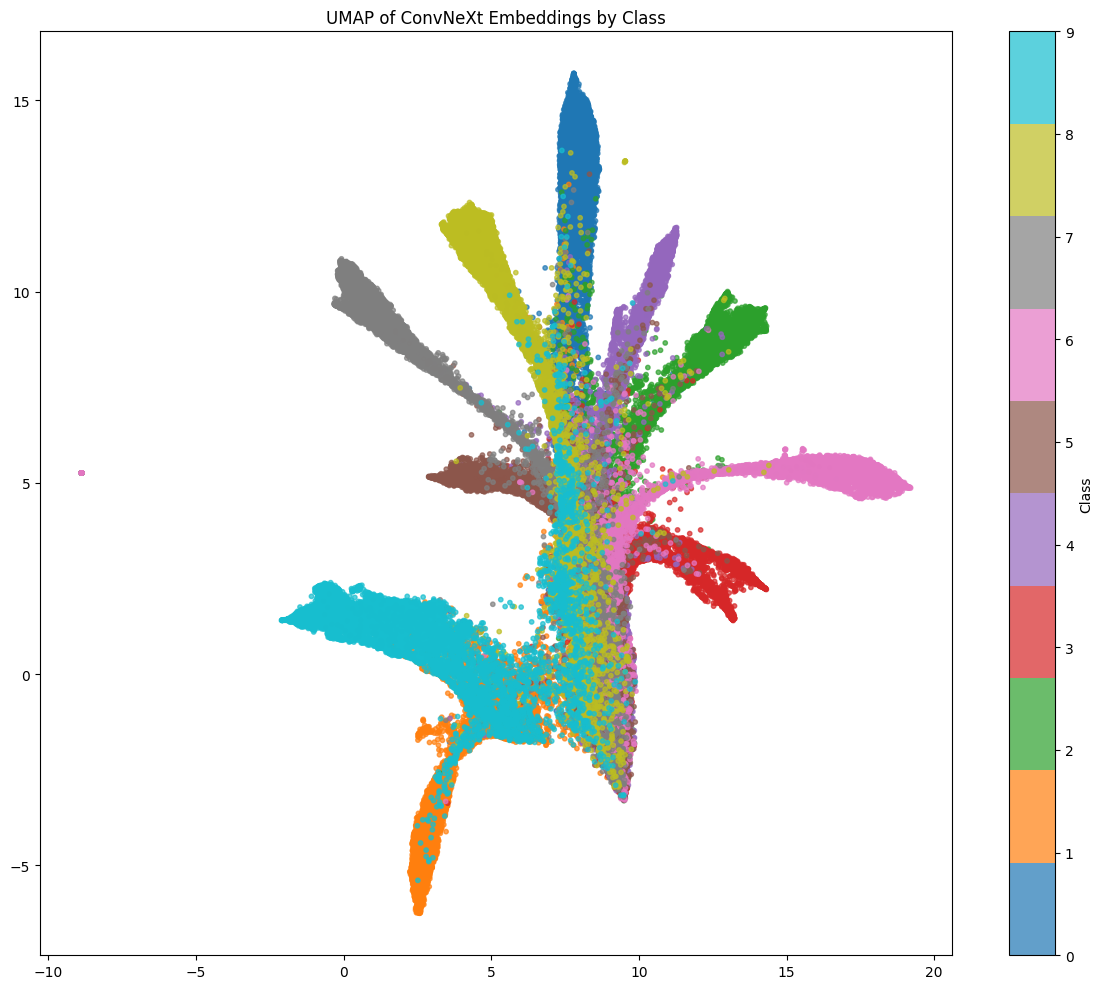

/tmp/ipykernel_939957/3141795934.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('coolwarm', 2),  # Red for unseen, blue for seen


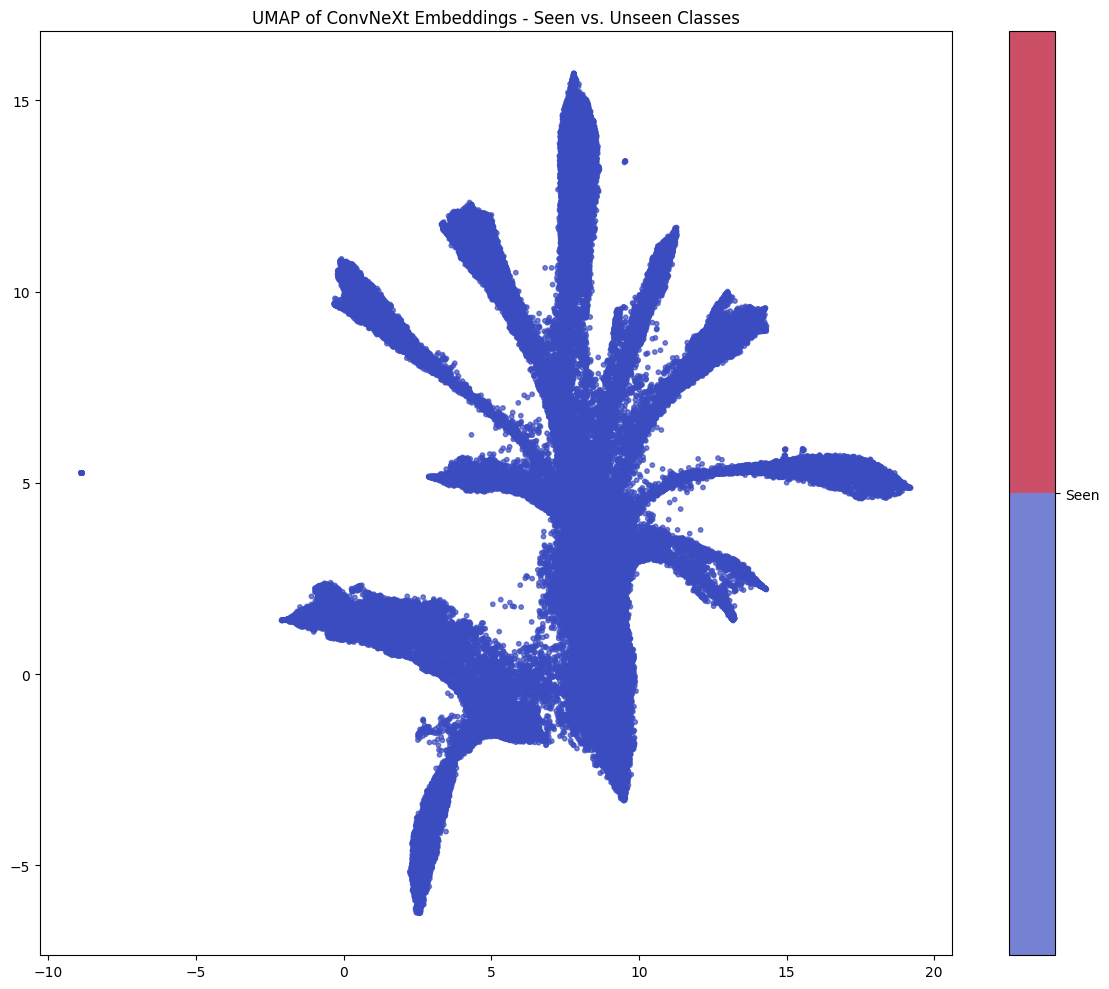

In [ ]:
# seen_classes = [c for c in range(args.num_base_classes) if c not in args.cls_drop]

# # Check if targets are in seen classes
# is_seen = np.isin(targets, seen_classes)

# # Create UMAP reducer
# reducer = umap.UMAP(
#     n_neighbors=15,  # Lower for more local structure, higher for more global
#     min_dist=0.1,    # Lower for tighter clusters
#     n_components=2,  # 2D for visualization
#     random_state=42  # For reproducibility
# )

# # Fit and transform the embeddings
# print("Computing UMAP (this may take a minute)...")
# embedding = reducer.fit_transform(embeddings)

# # Create plots
# plt.figure(figsize=(12, 10))

# # Color points by class
# scatter = plt.scatter(
#     embedding[:, 0], 
#     embedding[:, 1], 
#     c=targets, 
#     cmap='tab10', 
#     alpha=0.7,
#     s=10
# )

# # Add a colorbar
# plt.colorbar(scatter, label='Class')
# plt.title('UMAP of ConvNeXt Embeddings by Class')
# plt.tight_layout()
# plt.savefig('umap_by_class.png', dpi=300)
# plt.show()

# # If we have seen/unseen class information, create that plot too
# if is_seen is not None:
#     plt.figure(figsize=(12, 10))
    
#     # Create a scatter plot colored by seen/unseen status
#     scatter = plt.scatter(
#         embedding[:, 0], 
#         embedding[:, 1], 
#         c=is_seen, 
#         cmap=plt.cm.get_cmap('coolwarm', 2),  # Red for unseen, blue for seen
#         alpha=0.7,
#         s=10
#     )
    
#     # Add a colorbar with labels
#     cbar = plt.colorbar(scatter, ticks=[0, 1])
#     cbar.set_ticklabels(['Unseen', 'Seen'])
    
#     plt.title('UMAP of ConvNeXt Embeddings - Seen vs. Unseen Classes')
#     plt.tight_layout()
#     plt.savefig('umap_seen_unseen.png', dpi=300)
#     plt.show()

P/Q Binary Classifier

In [114]:
seen_classes = [c for c in range(args.num_base_classes) if c not in args.cls_drop]
is_seen = np.isin(targets, seen_classes)

P_indices = np.where(is_seen)[0] # indices of seen data
Q_indices = np.where(~is_seen)[0] # indices of unseen data

keep_size = np.min([np.sum(is_seen), np.sum(~is_seen)]) # keep the same number of seen and unseen data

P_indices = np.random.choice(P_indices, size=keep_size, replace=False)
Q_indices = np.random.choice(Q_indices, size=keep_size, replace=False)

P = embeddings[P_indices]
Q = embeddings[Q_indices]

In [115]:
from sklearn.linear_model import LogisticRegression

# Prepare training data
X_train = np.concatenate([P, Q], axis=0)
y_train = np.concatenate([np.zeros(len(P)), np.ones(len(Q))])

# Initialize and fit the logistic regression model
clf = LogisticRegression(random_state=seed, max_iter=1000)
clf.fit(X_train, y_train)

# Print the training accuracy
print("Training accuracy:", clf.score(X_train, y_train))

Training accuracy: 0.9674444444444444


/work3/nkale/miniconda3/envs/qmiaenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


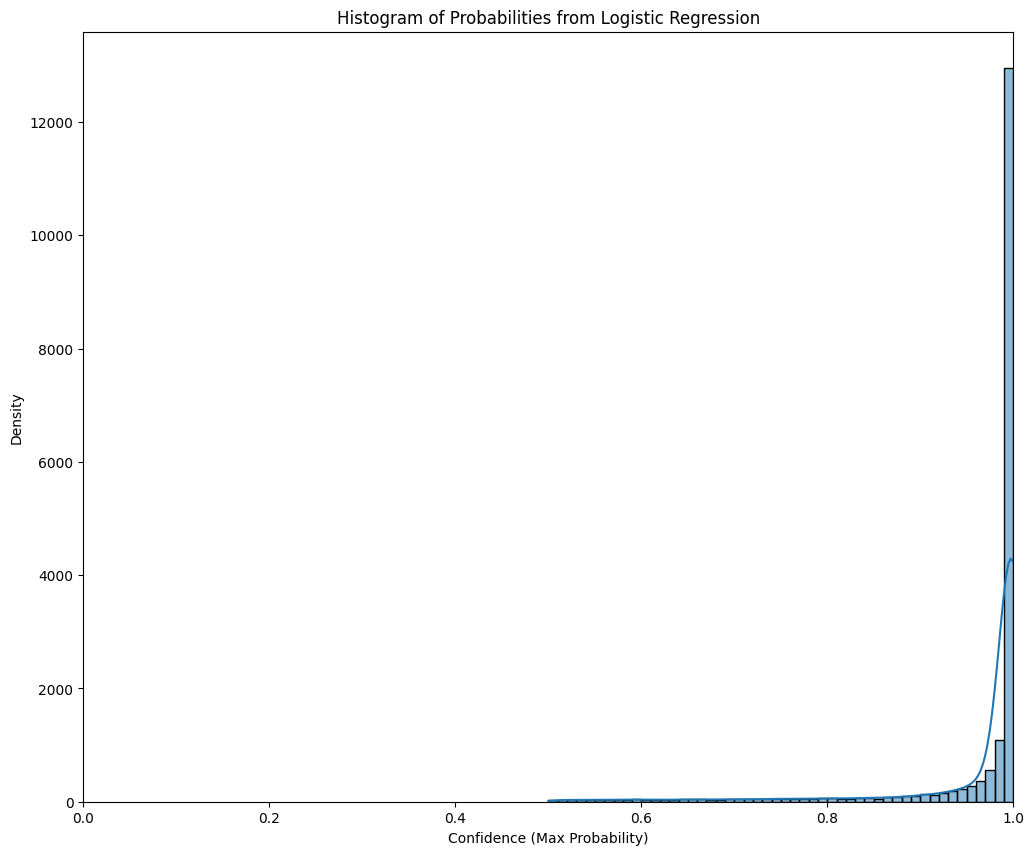

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

probabilities = clf.predict_proba(X_train)
probabilities = np.max(probabilities, axis=1)

plt.figure(figsize=(12, 10))
sns.histplot(probabilities, bins=50, kde=True)
plt.title('Histogram of Probabilities from Logistic Regression')
plt.xlabel('Confidence (Max Probability)')
plt.ylabel('Density')
plt.xlim(0, 1)
plt.show()

[P/Q -> Density Ratio] Linear Regressor

In [119]:
from sklearn.linear_model import LinearRegression

def density_ratio(P, clf):
    probs = clf.predict_proba(P)
    return probs[:, 1] / probs[:, 0]

# Prepare training data
X_train = np.concatenate([P, Q], axis=0)
y_train = np.concatenate([density_ratio(P, clf), density_ratio(Q, clf)])

# Initialize and fit the linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Print the training accuracy
print("Training R-Squared:", lin_reg.score(X_train, y_train))

Training R-Squared: 0.1699942690089985


### Gaussian Approach

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch

# Standard scale the data
scaler = StandardScaler()
scaled_embeds = scaler.fit_transform(embeddings)

# Reduce the embedding size
N_COMPONENTS = 2
pca = PCA(n_components=N_COMPONENTS)
pca_embeds = pca.fit_transform(scaled_embeds)

# Check if targets are in seen classes
seen_classes = [c for c in range(args.num_base_classes) if c not in args.cls_drop]
is_seen = np.isin(targets, seen_classes)

P_indices = np.where(is_seen)[0] # indices of seen data
Q_indices = range(len(targets)) # indices of all data

# keep_size = len(P_indices) # keep the same number of seen and unseen data
# Q_indices = np.random.choice(Q_indices, size=keep_size, replace=False)

P = torch.tensor(pca_embeds[P_indices]).to('cuda') # seen data
Q = torch.tensor(pca_embeds).to('cuda')  # all data

In [36]:
import torch
import numpy as np

from math import pi
from scipy.special import logsumexp

def calculate_matmul_n_times(n_components, mat_a, mat_b):
    """
    Calculate matrix product of two matrics with mat_a[0] >= mat_b[0].
    Bypasses torch.matmul to reduce memory footprint.
    args:
        mat_a:      torch.Tensor (n, k, 1, d)
        mat_b:      torch.Tensor (1, k, d, d)
    """
    res = torch.zeros(mat_a.shape).to(mat_a.device)
    
    for i in range(n_components):
        mat_a_i = mat_a[:, i, :, :].squeeze(-2)
        mat_b_i = mat_b[0, i, :, :].squeeze()
        res[:, i, :, :] = mat_a_i.mm(mat_b_i).unsqueeze(1)
    
    return res


def calculate_matmul(mat_a, mat_b):
    """
    Calculate matrix product of two matrics with mat_a[0] >= mat_b[0].
    Bypasses torch.matmul to reduce memory footprint.
    args:
        mat_a:      torch.Tensor (n, k, 1, d)
        mat_b:      torch.Tensor (n, k, d, 1)
    """
    assert mat_a.shape[-2] == 1 and mat_b.shape[-1] == 1
    return torch.sum(mat_a.squeeze(-2) * mat_b.squeeze(-1), dim=2, keepdim=True)

class GaussianMixture(torch.nn.Module):
    """
    Fits a mixture of k=1,..,K Gaussians to the input data (K is supplied via n_components).
    Input tensors are expected to be flat with dimensions (n: number of samples, d: number of features).
    The model then extends them to (n, 1, d).
    The model parametrization (mu, sigma) is stored as (1, k, d),
    probabilities are shaped (n, k, 1) if they relate to an individual sample,
    or (1, k, 1) if they assign membership probabilities to one of the mixture components.
    """
    def __init__(self, n_components, n_features, covariance_type="full", eps=1.e-6, init_params="kmeans", mu_init=None, var_init=None):
        """
        Initializes the model and brings all tensors into their required shape.
        The class expects data to be fed as a flat tensor in (n, d).
        The class owns:
            x:               torch.Tensor (n, 1, d)
            mu:              torch.Tensor (1, k, d)
            var:             torch.Tensor (1, k, d) or (1, k, d, d)
            pi:              torch.Tensor (1, k, 1)
            covariance_type: str
            eps:             float
            init_params:     str
            log_likelihood:  float
            n_components:    int
            n_features:      int
        args:
            n_components:    int
            n_features:      int
        options:
            mu_init:         torch.Tensor (1, k, d)
            var_init:        torch.Tensor (1, k, d) or (1, k, d, d)
            covariance_type: str
            eps:             float
            init_params:     str
        """
        super(GaussianMixture, self).__init__()

        self.n_components = n_components
        self.n_features = n_features

        self.mu_init = mu_init
        self.var_init = var_init
        self.eps = eps

        self.log_likelihood = -np.inf

        self.covariance_type = covariance_type
        self.init_params = init_params

        assert self.covariance_type in ["full", "diag"]
        assert self.init_params in ["kmeans", "random"]

        self._init_params()


    def _init_params(self):
        if self.mu_init is not None:
            assert self.mu_init.size() == (1, self.n_components, self.n_features), "Input mu_init does not have required tensor dimensions (1, %i, %i)" % (self.n_components, self.n_features)
            # (1, k, d)
            self.mu = torch.nn.Parameter(self.mu_init, requires_grad=False)
        else:
            self.mu = torch.nn.Parameter(torch.randn(1, self.n_components, self.n_features), requires_grad=False)

        if self.covariance_type == "diag":
            if self.var_init is not None:
                # (1, k, d)
                assert self.var_init.size() == (1, self.n_components, self.n_features), "Input var_init does not have required tensor dimensions (1, %i, %i)" % (self.n_components, self.n_features)
                self.var = torch.nn.Parameter(self.var_init, requires_grad=False)
            else:
                self.var = torch.nn.Parameter(torch.ones(1, self.n_components, self.n_features), requires_grad=False)
        elif self.covariance_type == "full":
            if self.var_init is not None:
                # (1, k, d, d)
                assert self.var_init.size() == (1, self.n_components, self.n_features, self.n_features), "Input var_init does not have required tensor dimensions (1, %i, %i, %i)" % (self.n_components, self.n_features, self.n_features)
                self.var = torch.nn.Parameter(self.var_init, requires_grad=False)
            else:
                self.var = torch.nn.Parameter(
                    torch.eye(self.n_features).reshape(1, 1, self.n_features, self.n_features).repeat(1, self.n_components, 1, 1),
                    requires_grad=False
                )

        # (1, k, 1)
        self.pi = torch.nn.Parameter(torch.Tensor(1, self.n_components, 1), requires_grad=False).fill_(1. / self.n_components)
        self.params_fitted = False


    def check_size(self, x):
        if len(x.size()) == 2:
            # (n, d) --> (n, 1, d)
            x = x.unsqueeze(1)

        return x


    def bic(self, x):
        """
        Bayesian information criterion for a batch of samples.
        args:
            x:      torch.Tensor (n, d) or (n, 1, d)
        returns:
            bic:    float
        """
        x = self.check_size(x)
        n = x.shape[0]

        # Free parameters for covariance, means and mixture components
        free_params = self.n_features * self.n_components + self.n_features + self.n_components - 1

        bic = -2. * self.__score(x, as_average=False).mean() * n + free_params * np.log(n)

        return bic


    def fit(self, x, delta=1e-3, n_iter=100, warm_start=False):
        """
        Fits model to the data.
        args:
            x:          torch.Tensor (n, d) or (n, k, d)
        options:
            delta:      float
            n_iter:     int
            warm_start: bool
        """
        if not warm_start and self.params_fitted:
            self._init_params()

        x = self.check_size(x)

        if self.init_params == "kmeans" and self.mu_init is None:
            mu = self.get_kmeans_mu(x, n_centers=self.n_components)
            self.mu.data = mu

        i = 0
        j = np.inf

        while (i <= n_iter) and (j >= delta):

            log_likelihood_old = self.log_likelihood
            mu_old = self.mu
            var_old = self.var

            self.__em(x)
            self.log_likelihood = self.__score(x)

            if torch.isinf(self.log_likelihood.abs()) or torch.isnan(self.log_likelihood):
                device = self.mu.device
                # When the log-likelihood assumes unbound values, reinitialize model
                self.__init__(self.n_components,
                    self.n_features,
                    covariance_type=self.covariance_type,
                    mu_init=self.mu_init,
                    var_init=self.var_init,
                    eps=self.eps)
                for p in self.parameters():
                    p.data = p.data.to(device)
                if self.init_params == "kmeans":
                    self.mu.data, = self.get_kmeans_mu(x, n_centers=self.n_components)

            i += 1
            j = self.log_likelihood - log_likelihood_old

            if j <= delta:
                # When score decreases, revert to old parameters
                self.__update_mu(mu_old)
                self.__update_var(var_old)

            print("Iteration %i, log-likelihood: %.3f, delta: %.3f" % (i, self.log_likelihood, j))

        self.params_fitted = True


    def predict(self, x, probs=False):
        """
        Assigns input data to one of the mixture components by evaluating the likelihood under each.
        If probs=True returns normalized probabilities of class membership.
        args:
            x:          torch.Tensor (n, d) or (n, 1, d)
            probs:      bool
        returns:
            p_k:        torch.Tensor (n, k)
            (or)
            y:          torch.LongTensor (n)
        """
        x = self.check_size(x)

        weighted_log_prob = self._estimate_log_prob(x) + torch.log(self.pi)

        if probs:
            p_k = torch.exp(weighted_log_prob)
            return torch.squeeze(p_k / (p_k.sum(1, keepdim=True)))
        else:
            return torch.squeeze(torch.max(weighted_log_prob, 1)[1].type(torch.LongTensor))


    def predict_proba(self, x):
        """
        Returns normalized probabilities of class membership.
        args:
            x:          torch.Tensor (n, d) or (n, 1, d)
        returns:
            y:          torch.LongTensor (n)
        """
        return self.predict(x, probs=True)


    def sample(self, n):
        """
        Samples from the model.
        args:
            n:          int
        returns:
            x:          torch.Tensor (n, d)
            y:          torch.Tensor (n)
        """
        counts = torch.distributions.multinomial.Multinomial(total_count=n, probs=self.pi.squeeze()).sample()
        x = torch.empty(0, device=counts.device)
        y = torch.cat([torch.full([int(sample)], j, device=counts.device) for j, sample in enumerate(counts)])

        # Only iterate over components with non-zero counts
        for k in np.arange(self.n_components)[counts > 0]: 
            if self.covariance_type == "diag":
                x_k = self.mu[0, k] + torch.randn(int(counts[k]), self.n_features, device=x.device) * torch.sqrt(self.var[0, k])
            elif self.covariance_type == "full":
                d_k = torch.distributions.multivariate_normal.MultivariateNormal(self.mu[0, k], self.var[0, k])
                x_k = torch.stack([d_k.sample() for _ in range(int(counts[k]))])

            x = torch.cat((x, x_k), dim=0)

        return x, y


    def score_samples(self, x):
        """
        Computes log-likelihood of samples under the current model.
        args:
            x:          torch.Tensor (n, d) or (n, 1, d)
        returns:
            score:      torch.LongTensor (n)
        """
        x = self.check_size(x)

        score = self.__score(x, as_average=False)
        return score


    def _estimate_log_prob(self, x):
        """
        Returns a tensor with dimensions (n, k, 1), which indicates the log-likelihood that samples belong to the k-th Gaussian.
        args:
            x:            torch.Tensor (n, d) or (n, 1, d)
        returns:
            log_prob:     torch.Tensor (n, k, 1)
        """
        x = self.check_size(x)

        if self.covariance_type == "full":
            mu = self.mu
            var = self.var

            precision = torch.inverse(var)
            d = x.shape[-1]

            log_2pi = d * np.log(2. * pi)

            log_det = self._calculate_log_det(precision)

            x_mu_T = (x - mu).unsqueeze(-2)
            x_mu = (x - mu).unsqueeze(-1)

            x_mu_T_precision = calculate_matmul_n_times(self.n_components, x_mu_T, precision)
            x_mu_T_precision_x_mu = calculate_matmul(x_mu_T_precision, x_mu)

            return -.5 * (log_2pi - log_det + x_mu_T_precision_x_mu)

        elif self.covariance_type == "diag":
            mu = self.mu
            prec = torch.rsqrt(self.var)

            log_p = torch.sum((mu * mu + x * x - 2 * x * mu) * prec, dim=2, keepdim=True)
            log_det = torch.sum(torch.log(prec), dim=2, keepdim=True)

            return -.5 * (self.n_features * np.log(2. * pi) + log_p - log_det)


    def _calculate_log_det(self, var):
        """
        Calculate log determinant in log space, to prevent overflow errors.
        args:
            var:            torch.Tensor (1, k, d, d)
        """
        log_det = torch.empty(size=(self.n_components,)).to(var.device)
        
        for k in range(self.n_components):
            log_det[k] = 2 * torch.log(torch.diagonal(torch.linalg.cholesky(var[0,k]))).sum()

        return log_det.unsqueeze(-1)


    def _e_step(self, x):
        """
        Computes log-responses that indicate the (logarithmic) posterior belief (sometimes called responsibilities) that a data point was generated by one of the k mixture components.
        Also returns the mean of the mean of the logarithms of the probabilities (as is done in sklearn).
        This is the so-called expectation step of the EM-algorithm.
        args:
            x:              torch.Tensor (n, d) or (n, 1, d)
        returns:
            log_prob_norm:  torch.Tensor (1)
            log_resp:       torch.Tensor (n, k, 1)
        """
        x = self.check_size(x)

        weighted_log_prob = self._estimate_log_prob(x) + torch.log(self.pi)

        log_prob_norm = torch.logsumexp(weighted_log_prob, dim=1, keepdim=True)
        log_resp = weighted_log_prob - log_prob_norm

        return torch.mean(log_prob_norm), log_resp


    def _m_step(self, x, log_resp):
        """
        From the log-probabilities, computes new parameters pi, mu, var (that maximize the log-likelihood). This is the maximization step of the EM-algorithm.
        args:
            x:          torch.Tensor (n, d) or (n, 1, d)
            log_resp:   torch.Tensor (n, k, 1)
        returns:
            pi:         torch.Tensor (1, k, 1)
            mu:         torch.Tensor (1, k, d)
            var:        torch.Tensor (1, k, d)
        """
        x = self.check_size(x)

        resp = torch.exp(log_resp)

        pi = torch.sum(resp, dim=0, keepdim=True) + self.eps
        mu = torch.sum(resp * x, dim=0, keepdim=True) / pi

        if self.covariance_type == "full":
            eps = (torch.eye(self.n_features) * self.eps).to(x.device)
            var = torch.sum((x - mu).unsqueeze(-1).matmul((x - mu).unsqueeze(-2)) * resp.unsqueeze(-1), dim=0,
                            keepdim=True) / torch.sum(resp, dim=0, keepdim=True).unsqueeze(-1) + eps

        elif self.covariance_type == "diag":
            x2 = (resp * x * x).sum(0, keepdim=True) / pi
            mu2 = mu * mu
            xmu = (resp * mu * x).sum(0, keepdim=True) / pi
            var = x2 - 2 * xmu + mu2 + self.eps

        pi = pi / x.shape[0]

        return pi, mu, var


    def __em(self, x):
        """
        Performs one iteration of the expectation-maximization algorithm by calling the respective subroutines.
        args:
            x:          torch.Tensor (n, 1, d)
        """
        _, log_resp = self._e_step(x)
        pi, mu, var = self._m_step(x, log_resp)

        self.__update_pi(pi)
        self.__update_mu(mu)
        self.__update_var(var)


    def __score(self, x, as_average=True):
        """
        Computes the log-likelihood of the data under the model.
        args:
            x:                  torch.Tensor (n, 1, d)
            sum_data:           bool
        returns:
            score:              torch.Tensor (1)
            (or)
            per_sample_score:   torch.Tensor (n)

        """
        weighted_log_prob = self._estimate_log_prob(x) + torch.log(self.pi)
        per_sample_score = torch.logsumexp(weighted_log_prob, dim=1)

        if as_average:
            return per_sample_score.mean()
        else:
            return torch.squeeze(per_sample_score)


    def __update_mu(self, mu):
        """
        Updates mean to the provided value.
        args:
            mu:         torch.FloatTensor
        """
        assert mu.size() in [(self.n_components, self.n_features), (1, self.n_components, self.n_features)], "Input mu does not have required tensor dimensions (%i, %i) or (1, %i, %i)" % (self.n_components, self.n_features, self.n_components, self.n_features)

        if mu.size() == (self.n_components, self.n_features):
            self.mu = mu.unsqueeze(0)
        elif mu.size() == (1, self.n_components, self.n_features):
            self.mu.data = mu


    def __update_var(self, var):
        """
        Updates variance to the provided value.
        args:
            var:        torch.FloatTensor
        """
        if self.covariance_type == "full":
            assert var.size() in [(self.n_components, self.n_features, self.n_features), (1, self.n_components, self.n_features, self.n_features)], "Input var does not have required tensor dimensions (%i, %i, %i) or (1, %i, %i, %i)" % (self.n_components, self.n_features, self.n_features, self.n_components, self.n_features, self.n_features)

            if var.size() == (self.n_components, self.n_features, self.n_features):
                self.var = var.unsqueeze(0)
            elif var.size() == (1, self.n_components, self.n_features, self.n_features):
                self.var.data = var

        elif self.covariance_type == "diag":
            assert var.size() in [(self.n_components, self.n_features), (1, self.n_components, self.n_features)], "Input var does not have required tensor dimensions (%i, %i) or (1, %i, %i)" % (self.n_components, self.n_features, self.n_components, self.n_features)

            if var.size() == (self.n_components, self.n_features):
                self.var = var.unsqueeze(0)
            elif var.size() == (1, self.n_components, self.n_features):
                self.var.data = var


    def __update_pi(self, pi):
        """
        Updates pi to the provided value.
        args:
            pi:         torch.FloatTensor
        """
        assert pi.size() in [(1, self.n_components, 1)], "Input pi does not have required tensor dimensions (%i, %i, %i)" % (1, self.n_components, 1)

        self.pi.data = pi


    def get_kmeans_mu(self, x, n_centers, init_times=50, min_delta=1e-3):
        """
        Find an initial value for the mean. Requires a threshold min_delta for the k-means algorithm to stop iterating.
        The algorithm is repeated init_times often, after which the best centerpoint is returned.
        args:
            x:            torch.FloatTensor (n, d) or (n, 1, d)
            init_times:   init
            min_delta:    int
        """
        if len(x.size()) == 3:
            x = x.squeeze(1)
        x_min, x_max = x.min(), x.max()
        x = (x - x_min) / (x_max - x_min)
        
        min_cost = np.inf

        for i in range(init_times):
            tmp_center = x[np.random.choice(np.arange(x.shape[0]), size=n_centers, replace=False), ...]
            l2_dis = torch.norm((x.unsqueeze(1).repeat(1, n_centers, 1) - tmp_center), p=2, dim=2)
            l2_cls = torch.argmin(l2_dis, dim=1)

            cost = 0
            for c in range(n_centers):
                cost += torch.norm(x[l2_cls == c] - tmp_center[c], p=2, dim=1).mean()

            if cost < min_cost:
                min_cost = cost
                center = tmp_center

        delta = np.inf

        while delta > min_delta:
            l2_dis = torch.norm((x.unsqueeze(1).repeat(1, n_centers, 1) - center), p=2, dim=2)
            l2_cls = torch.argmin(l2_dis, dim=1)
            center_old = center.clone()

            for c in range(n_centers):
                center[c] = x[l2_cls == c].mean(dim=0)

            delta = torch.norm((center_old - center), dim=1).max()

        return (center.unsqueeze(0)*(x_max - x_min) + x_min)

In [37]:
import torch
import numpy as np
import os

# Number of components for each GMM
n_components_P = args.num_base_classes - len(args.cls_drop)
n_components_Q = args.num_base_classes

# Fit GMM to P
gmm_P = GaussianMixture(n_components_P, N_COMPONENTS, covariance_type="full").to('cuda')
gmm_P.fit(P, n_iter=1000, delta=1e-6)

# Fit GMM to Q
gmm_Q = GaussianMixture(n_components_Q, N_COMPONENTS, covariance_type="full").to('cuda')
gmm_Q.fit(Q, n_iter=1000, delta=1e-6)

Iteration 1, log-likelihood: -7.192, delta: inf
Iteration 2, log-likelihood: -7.147, delta: 0.045
Iteration 3, log-likelihood: -7.134, delta: 0.013
Iteration 4, log-likelihood: -7.128, delta: 0.006
Iteration 5, log-likelihood: -7.124, delta: 0.003
Iteration 6, log-likelihood: -7.122, delta: 0.002
Iteration 7, log-likelihood: -7.121, delta: 0.001
Iteration 8, log-likelihood: -7.120, delta: 0.001
Iteration 9, log-likelihood: -7.119, delta: 0.001
Iteration 10, log-likelihood: -7.119, delta: 0.001
Iteration 11, log-likelihood: -7.118, delta: 0.000
Iteration 12, log-likelihood: -7.118, delta: 0.000
Iteration 13, log-likelihood: -7.118, delta: 0.000
Iteration 14, log-likelihood: -7.118, delta: 0.000
Iteration 15, log-likelihood: -7.117, delta: 0.000
Iteration 16, log-likelihood: -7.117, delta: 0.000
Iteration 17, log-likelihood: -7.117, delta: 0.000
Iteration 18, log-likelihood: -7.117, delta: 0.000
Iteration 19, log-likelihood: -7.117, delta: 0.000
Iteration 20, log-likelihood: -7.117, delt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib import rcParams

def simple_gmm_visualization(P, Q, gmm_P, gmm_Q):
    """
    Simple visualization of 2D data and GMM contours.
    """
    # Convert tensors to numpy if needed
    if isinstance(P, torch.Tensor):
        P = P.cpu().numpy()
    if isinstance(Q, torch.Tensor):
        Q = Q.cpu().numpy()
    
    # Create a mesh grid for contours
    x_min, x_max = min(P[:, 0].min(), Q[:, 0].min()) - 1, max(P[:, 0].max(), Q[:, 0].max()) + 1
    y_min, y_max = min(P[:, 1].min(), Q[:, 1].min()) - 1, max(P[:, 1].max(), Q[:, 1].max()) + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Convert mesh points to tensor and move to the same device as the GMMs
    device = next(gmm_P.parameters()).device
    mesh_tensor = torch.tensor(mesh_points, dtype=torch.float32).to(device)
    
    # Get densities using score_samples method
    P_log_density = gmm_P.score_samples(mesh_tensor).reshape(xx.shape).cpu()
    Q_log_density = gmm_Q.score_samples(mesh_tensor).reshape(xx.shape).cpu()
    
    # Convert log densities to regular densities
    P_density = np.exp(P_log_density)
    Q_density = np.exp(Q_log_density)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    rcParams['font.family'] = 'Linux Libertine O'
    rcParams['font.size']=20

    # Fix same colorscale for both plots
    colors = plt.cm.tab10(np.linspace(0, 1, args.num_base_classes))
    
    # Plot P data and GMM
    for i in seen_classes:
        ax1.scatter(P[targets[P_indices] == i, 0], P[targets[P_indices] == i, 1], s=5, alpha=0.4, label=f'Class {i}', color=colors[i])
    # ax1.scatter(P[:, 0], P[:, 1], s=10, alpha=0.6, c='blue', label='P Data')
    ax1.contour(xx, yy, P_density, levels=10, colors='black', alpha=0.8)
    ax1.set_title('P Dataset and GMM')
    ax1.set_xlabel('PCA Component 1')
    ax1.set_ylabel('PCA Component 2')
    ax1.legend()
    
    # Plot Q data and GMM
    for i in range(args.num_base_classes):
        ax2.scatter(Q[targets[Q_indices] == i, 0], Q[targets[Q_indices] == i, 1], s=5, alpha=0.4, label=f'Class {i}', color=colors[i])
    # ax2.scatter(Q[:, 0], Q[:, 1], s=10, alpha=0.6, c='red', label='Q Data')
    ax2.contour(xx, yy, Q_density, levels=10, colors='black', alpha=0.8)
    ax2.set_title('Q Dataset and GMM')
    ax2.set_xlabel('PCA Component 1')
    ax2.set_ylabel('PCA Component 2')
    ax2.legend()
    
    plt.tight_layout()
    # plt.savefig('gmm_simple_visualization.png')    
    
# Usage example
simple_gmm_visualization(P, Q, gmm_P, gmm_Q)

NameError: name 'P' is not defined

In [62]:
def compute_density_ratio(gmm_P, gmm_Q, X):
    """
    Compute the density ratio P(x)/Q(x) for points in X
    
    Parameters:
    -----------
    gmm_P: GaussianMixture
        The numerator GMM (P)
    gmm_Q: GaussianMixture
        The denominator GMM (Q)
    X: torch.Tensor
        Points at which to evaluate the density ratio (n, d) or (n, 1, d)
        
    Returns:
    --------
    torch.Tensor
        Density ratio values for each point in X (n)
    """
    # Get log probabilities from each model
    # The score_samples method returns log probabilities
    log_prob_P = gmm_P.score_samples(X)  # Returns (n)
    log_prob_Q = gmm_Q.score_samples(X)  # Returns (n)
    
    # Compute ratio in log space first (for numerical stability)
    log_ratio = log_prob_P - log_prob_Q
    
    # Convert to normal space
    ratio = torch.exp(log_ratio)

    return ratio

density_ratios = compute_density_ratio(gmm_P, gmm_Q, Q)

In [67]:
print("Median density ratio for seen classes:", torch.median(density_ratios[is_seen]).item())
print("Median density ratio for unseen classes:", torch.median(density_ratios[~is_seen]).item())

Median density ratio for seen classes: 1.0921858549118042
Median density ratio for unseen classes: 0.33430954813957214


Text(0.5, 0, 'Density Ratio (P(x)/Q(x))')

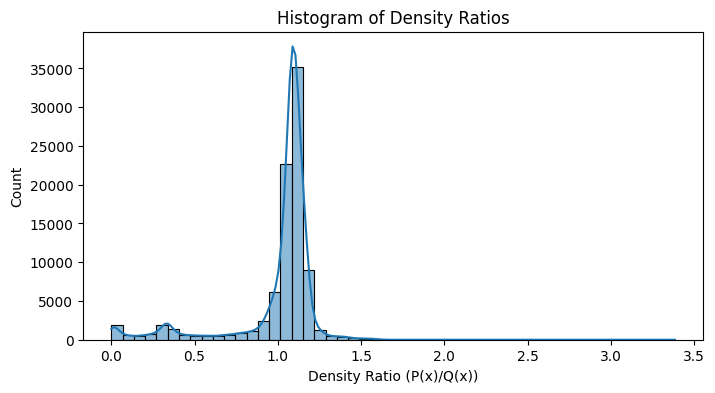

In [75]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(density_ratios.cpu().numpy(), bins=50, kde=True)
plt.title('Histogram of Density Ratios')
plt.xlabel('Density Ratio (P(x)/Q(x))')

Fit a Linear Regressor

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare training data
X_train = scaled_embeds
y_train = density_ratios.cpu().numpy()
# Initialize and fit the linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
# Print the training accuracy
y_pred = lin_reg.predict(X_train)
print("Training R-Squared:", r2_score(y_train, y_pred))
print("Training MSE:", mean_squared_error(y_train, y_pred))

Training R-Squared: 0.8831099271774292
Training MSE: 0.008108345791697502


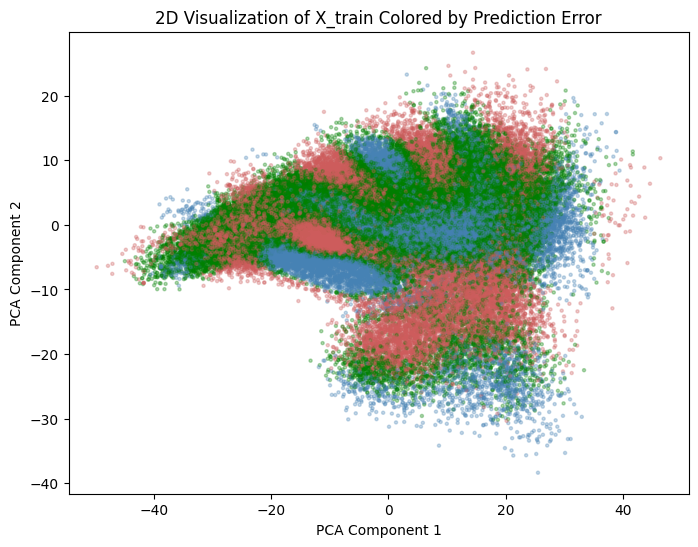

In [98]:
import matplotlib.pyplot as plt

# Compute prediction error: positive if prediction > ground truth, negative otherwise
errors = y_pred - y_train  # shape: (n_samples,)

# Reduce X_train to 2 dimensions for plotting
X_2d = Q.cpu().numpy()  # shape: (n_samples, 2)

# Color: red if error is positive, blue if negative
colors = ['green' if abs(err) < 0.05 else 'indianred' if err >= 0 else 'steelblue' for err in errors]

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=colors, s=5, alpha=0.3)
plt.title('2D Visualization of X_train Colored by Prediction Error')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()